In [19]:
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.tsa.api import VAR
from statsmodels.formula.api import ols
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

np.random.seed(42)

### Analisi Esplorativa dei dati

In [20]:
df = pandas.read_csv('data/theft_df.csv')

display(df)

,geo,year,theft,poverty,neet,education,unemployment,income,inequity
0,Austria,2016,1651.67,14.964810,8.091438,34.540870,3.828207,24400,4.09
1,Belgium,2016,2055.54,25.110680,13.799563,50.108248,5.316225,22267,3.85
2,Bulgaria,2016,457.48,29.330514,16.024476,23.464412,3.648430,3212,7.69
3,Cyprus,2016,86.17,1.917201,1.526974,4.767553,0.729554,14132,4.88
4,Czechia,2016,674.86,13.086765,11.714766,34.405528,2.743999,7905,3.50
...,...,...,...,...,...,...,...,...,...
157,Portugal,2021,621.02,23.068084,9.783339,48.916697,4.531231,11115,5.66
158,Romania,2021,471.44,66.245734,38.979374,44.739872,6.144532,4914,7.14
159,Sweden,2021,2784.26,17.852387,6.227577,51.169924,6.746542,25925,4.04
160,Slovenia,2021,634.76,2.783850,1.539553,10.102000,0.653783,15415,3.24


<Axes: >

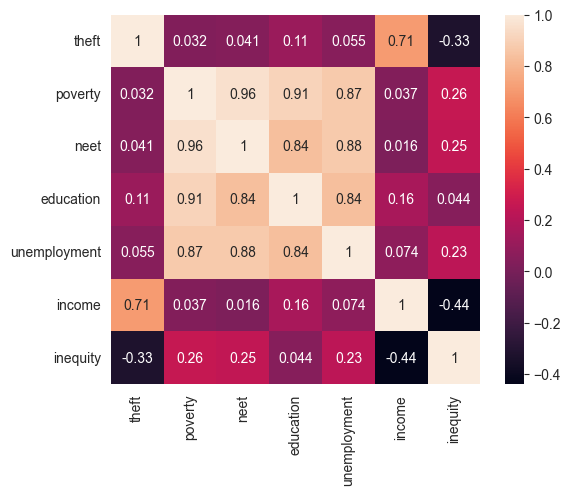

In [21]:
# Correlation Matrix

corrmat = df.drop(columns=["geo", "year"]).corr()

sns.heatmap(corrmat, square=True, annot=True)

In [33]:
#sns.pairplot(df.drop(columns=["geo", "year"]), hue="theft")

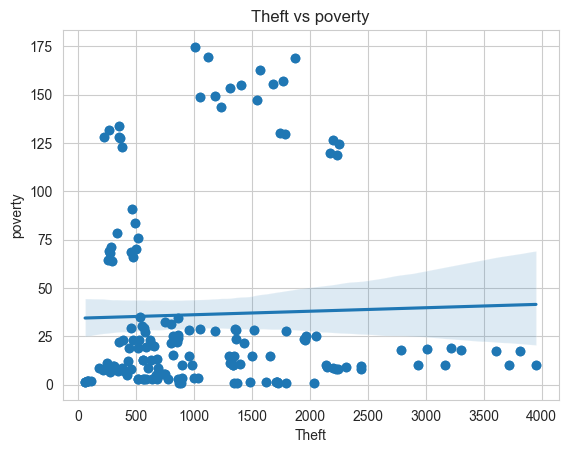

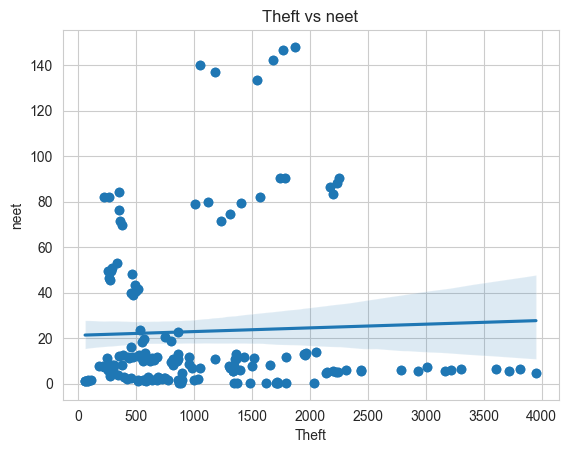

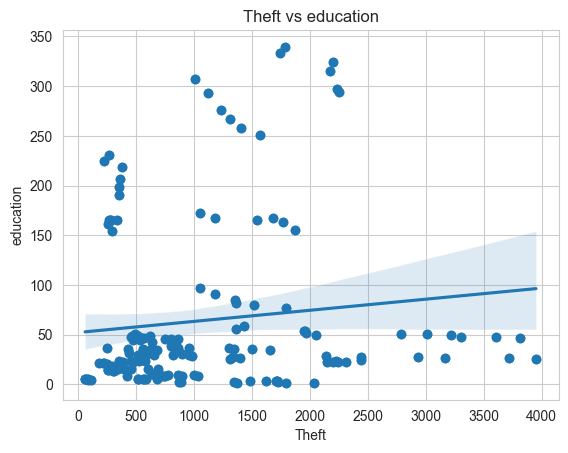

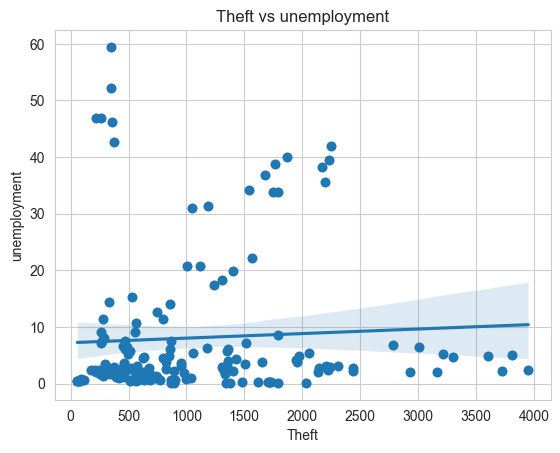

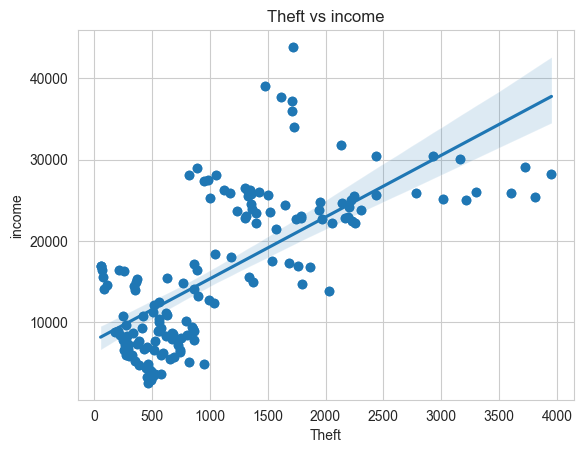

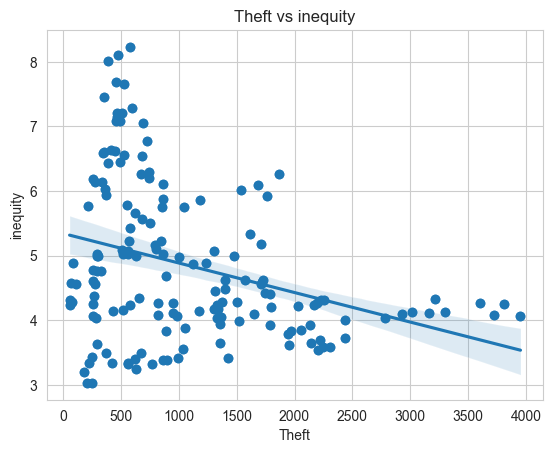

In [23]:
# Scatter Plot
features = ["poverty", "neet", "education", "unemployment", "income", "inequity"]

for feature in features:
    sns.regplot(x="theft", y=feature, data=df)
    plt.scatter(df["theft"], df[feature])
    plt.xlabel("Theft")
    plt.ylabel(feature)
    plt.title("Theft vs " + feature)
    plt.show()

# Modeling

In [24]:
X = df.drop(columns=["geo", "year", "theft"])
y = df["theft"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test, y_test)

0.4246409929016499

In [25]:
# ANOVA Model
model = ols("theft ~ poverty + neet + education + unemployment + income + inequity", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                    sum_sq     df           F        PR(>F)
poverty       3.737370e+05    1.0    0.995586  3.199360e-01
neet          8.477116e+05    1.0    2.258192  1.349438e-01
education     4.154306e+04    1.0    0.110665  7.398375e-01
unemployment  1.448869e+05    1.0    0.385960  5.353434e-01
income        4.480158e+07    1.0  119.345496  5.833401e-21
inequity      1.878107e+03    1.0    0.005003  9.437022e-01
Residual      5.818606e+07  155.0         NaN           NaN


https://www.w3schools.com/datascience/ds_linear_regression_pvalue.asp#:~:text=A%20low%20P%2Dvalue%20(%3C,called%20an%20insignificant%20P%2Dvalue.

scrivere che ho provato a normalizzare 


In [26]:
X2 = sm.add_constant(df.drop(columns=["geo", "year", "theft"]))
model = sm.OLS(y, X2)
estimator = model.fit()

test = model.fit_regularized(method='elastic_net', alpha=0.02, L1_wt=0, start_params= estimator.params)

results = sm.regression.linear_model.OLSResults(model, test.params, model.normalized_cov_params)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  theft   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     26.45
Date:                Thu, 02 Nov 2023   Prob (F-statistic):           1.52e-21
Time:                        17:15:05   Log-Likelihood:                -1266.0
No. Observations:                 162   AIC:                             2546.
Df Residuals:                     155   BIC:                             2568.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           35.7935    305.396      0.117   

In [27]:
hypothesis_0 = "poverty = 0, neet = 0, education = 0,  unemployment = 0, income = 0, inequity = 0"
print(results.t_test(hypothesis_0))


                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -5.3763      5.232     -1.028      0.306     -15.712       4.959
c1             8.4633      5.563      1.521      0.130      -2.525      19.452
c2             0.6599      1.788      0.369      0.713      -2.871       4.191
c3            -5.7393      8.952     -0.641      0.522     -23.423      11.944
c4             0.0658      0.006     10.983      0.000       0.054       0.078
c5             0.9200     53.327      0.017      0.986    -104.421     106.261


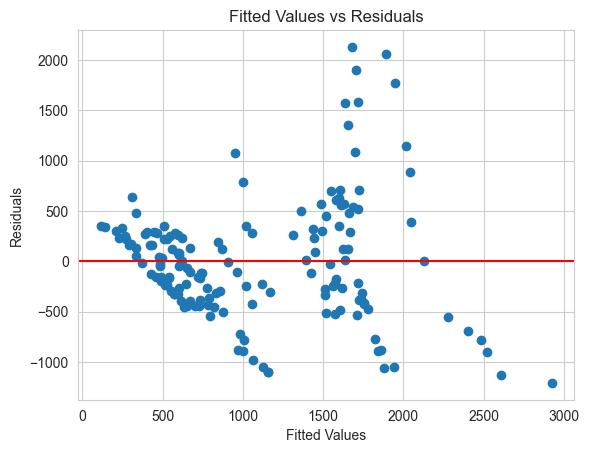

In [28]:
plt.scatter(results.fittedvalues, results.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values vs Residuals")
plt.axhline(y=0, color="red")
plt.show()

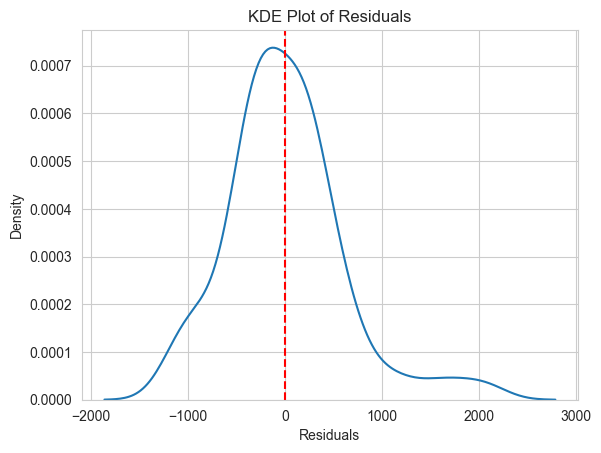

In [29]:
# KDE Plot of residuals
sns.kdeplot(results.resid)
plt.axvline(results.resid.mean(), linestyle='dashed', color="red")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("KDE Plot of Residuals")
plt.show()

In [30]:
#sm.graphics.plot_partregress_grid(results)

### Top 5 regions with the highest theft in total

In [31]:
data = df.drop(columns=["poverty", "neet", "education", "income", "inequity"])
display(data.groupby("geo").sum().sort_values(by="theft", ascending=False).head(5))

,year,theft,unemployment
geo,,,
Sweden,12111,19729.23,33.045199
Denmark,12111,18336.99,13.068319
Finland,12111,13562.49,17.199486
France,12111,12376.76,222.754406
Belgium,12111,10716.08,26.389722


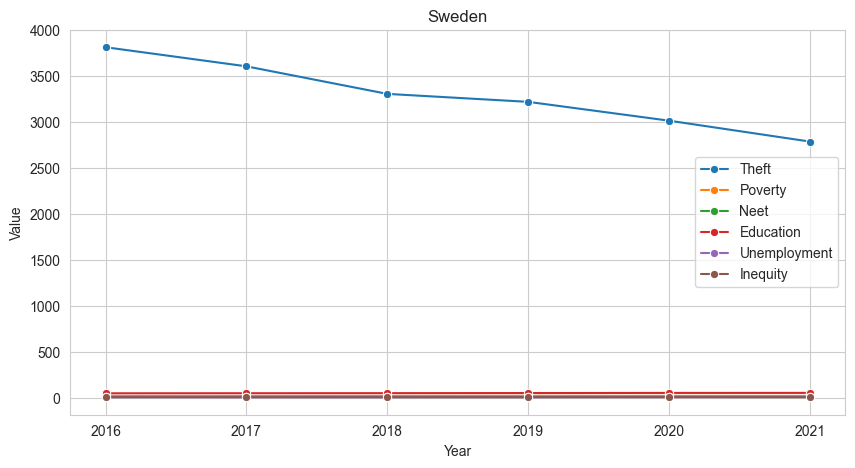

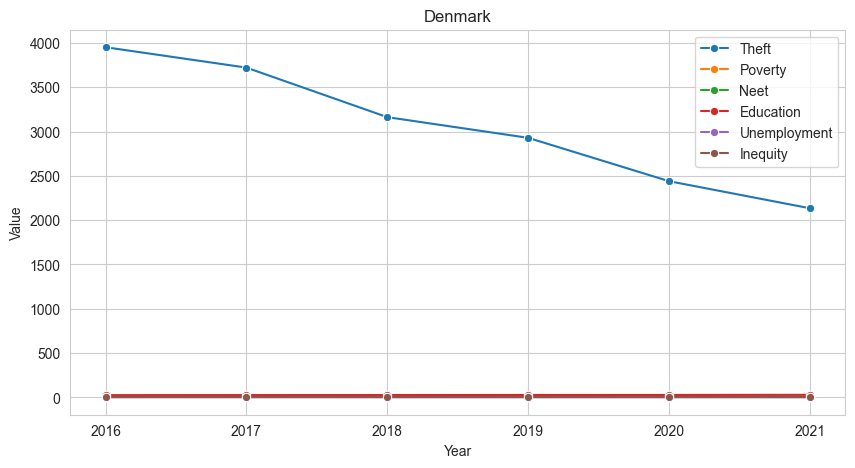

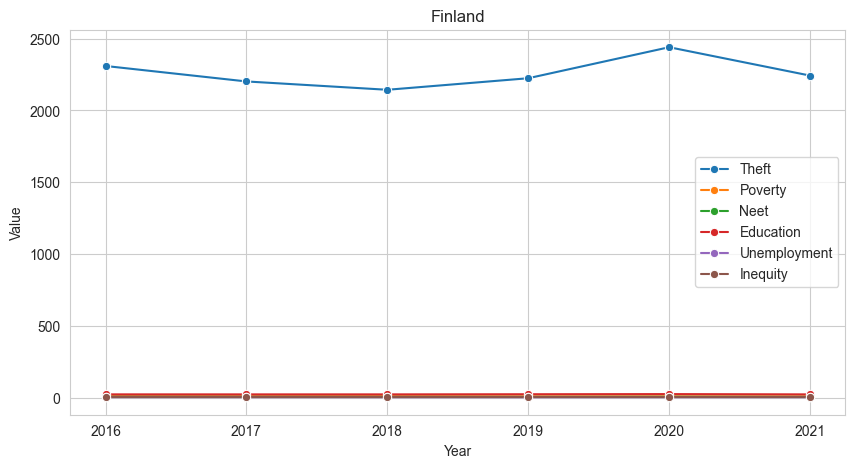

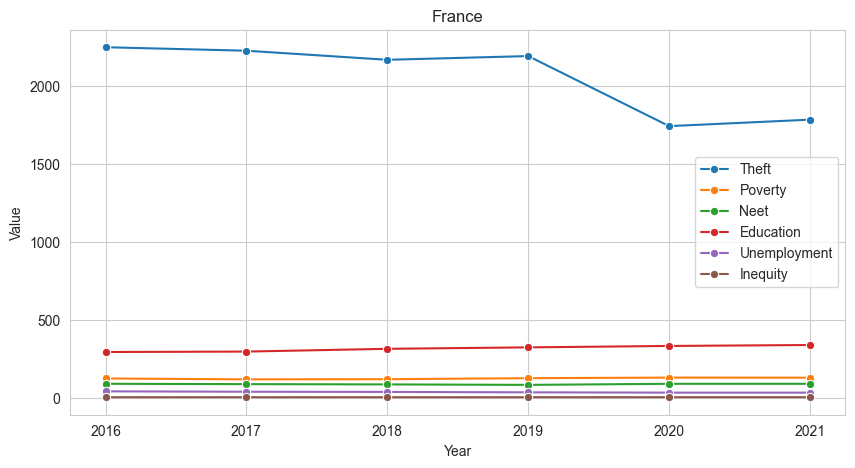

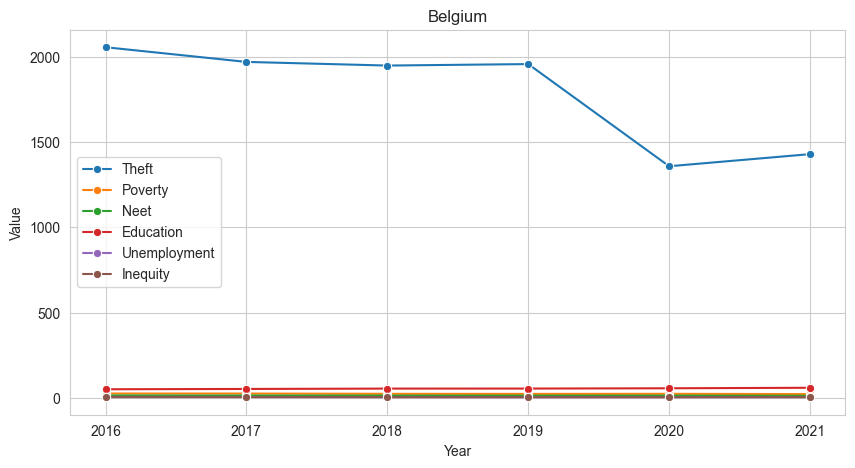

In [32]:
# Data Visualization

sweden = df[df["geo"] == "Sweden"]
denmark = df[df["geo"] == "Denmark"]
finland = df[df["geo"] == "Finland"]
france = df[df["geo"] == "France"]
belgium = df[df["geo"] == "Belgium"]

countries = [sweden, denmark, finland, france, belgium]

for country in countries:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="year", y="theft", data=country, label="Theft", marker="o")
    sns.lineplot(x="year", y="poverty", data=country, label="Poverty", marker="o")
    sns.lineplot(x="year", y="neet", data=country, label="Neet", marker="o")
    sns.lineplot(x="year", y="education", data=country, label="Education", marker="o")
    sns.lineplot(x="year", y="unemployment", data=country, label="Unemployment", marker="o")
    #sns.lineplot(x="year", y="income", data=country, label="Income", marker="o")
    sns.lineplot(x="year", y="inequity", data=country, label="Inequity", marker="o")
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.title(country["geo"].iloc[0])
    plt.show()